### O desafio

A Frexco trabalha com **produtos perecíveis** e muitos deles possuem uma data de **validade curta**. Acertar na previsão de demanda é essencial para **evitar o desperdício de alimentos**, além de **garantir que a disponibilidade do produto no estoque para venda**.

Tendo isso em mente, estruture um script no Python que calcule a **previsão de demanda para os próximos 5 dias** do item, baseando-se no histórico presente na base de dados em anexo.


### Preparação do ambiente

Pacotes e importação dos dados

In [1]:
#base
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#modelo
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA

In [2]:
vendas = pd.read_excel('Dados.xlsx', index_col='Data', parse_dates=True)

Descrição da série

In [3]:
vendas.head()

,Vendas
Data,
2022-12-06,870
2022-12-07,868
2022-12-08,1189
2022-12-09,742
2022-12-10,317


In [4]:
#Número de observações (linhas, colunas)
vendas.shape

(46, 1)

In [5]:
#Medidas descritivas das vendas
vendas.describe()

,Vendas
count,46.000000
mean,755.434783
std,430.762201
min,18.000000
25%,346.500000
50%,810.500000
75%,1053.750000
max,1692.000000


In [6]:
# Primeiro é o último dia da série
vendas.index.min(), vendas.index.max()

(Timestamp('2022-12-06 00:00:00'), Timestamp('2023-01-20 00:00:00'))

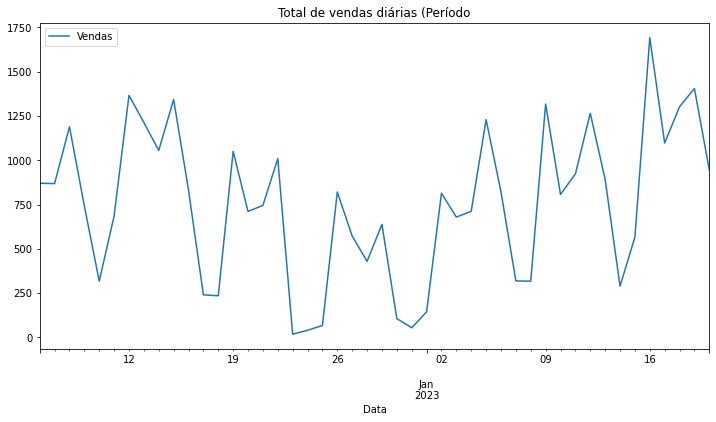

In [7]:
#Visualização da série
vendas.plot(figsize=(12,6))
plt.title('Total de vendas diárias (Período')
plt.show()

### Construção do modelo

Através da visualização da série, podemos perceber que a série não é estacionária, pois apresenta tendência e sazonalidade. Para que a série seja estacionária, é necessário realizar a diferenciação da série.

A suposição é  confirmada usando a função de decomposição do pacote statsmodels.

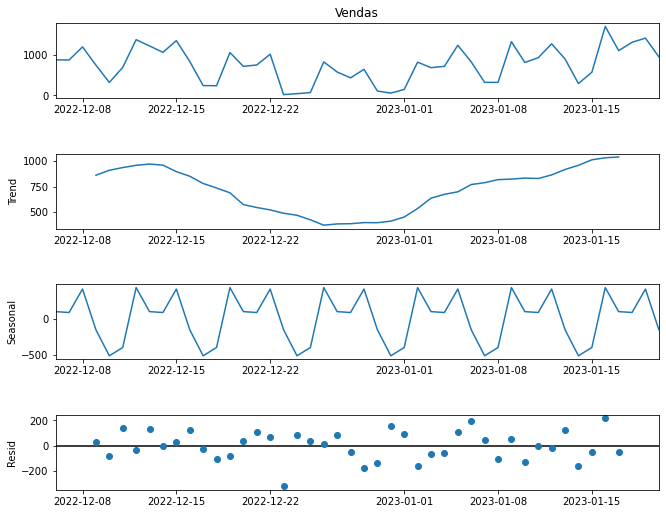

In [8]:
#Decomposição da série
resultado = seasonal_decompose(vendas['Vendas'])
resultado.plot().set_size_inches(10,8)
plt.show()

Teste de estacionariedade

In [9]:
result=adfuller(vendas['Vendas'])
print(f'Teste ADF:{result[0]}')
print(f'p-valor:{result[1]}')

Teste ADF:-1.507607361196456
p-valor:0.5297447855798443


In [10]:
def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Estatística','p-valor','#Defasagem','Número de observações']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("Rejeita-se a hipótese nula. A série não possui raiz unitária e é estacionária")
    else:
        print("Rejeita-se a hipótese alternativa. A série possui raiz unitária, indicando não estacionariedade")
    

In [11]:
adfuller_test(vendas['Vendas'])

ADF Estatística : -1.507607361196456
p-valor : 0.5297447855798443
#Defasagem : 7
Número de observações : 38
Rejeita-se a hipótese alternativa. A série possui raiz unitária, indicando não estacionariedade


In [12]:
vendas['Primeira Diferença'] = vendas['Vendas'] - vendas['Vendas'].shift(1)

In [13]:
adfuller_test(vendas['Primeira Diferença'].dropna())

ADF Estatística : -2.174417283436759
p-valor : 0.21566116101896976
#Defasagem : 6
Número de observações : 38
Rejeita-se a hipótese alternativa. A série possui raiz unitária, indicando não estacionariedade


Construção do ARIMA

In [14]:
fit_arima = auto_arima(vendas['Vendas'], d=1, start_p=1, start_q=1, max_p=3, max_q=3,
                       seasonal=True,
                       m=7,
                       max_P=3,
                       max_Q=3,
                       information_criterion='aic',
                       trace=True,
                       error_action='ignore',
                       stepwise=True)


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[7]             : AIC=inf, Time=0.37 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=523.044, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=522.829, Time=0.12 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=516.979, Time=0.12 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=521.870, Time=0.03 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=inf, Time=0.36 sec
 ARIMA(0,1,1)(0,1,2)[7]             : AIC=inf, Time=0.38 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=522.140, Time=0.09 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=inf, Time=0.49 sec
 ARIMA(0,1,0)(0,1,1)[7]             : AIC=521.754, Time=0.07 sec
 ARIMA(1,1,1)(0,1,1)[7]             : AIC=inf, Time=0.25 sec
 ARIMA(0,1,2)(0,1,1)[7]             : AIC=inf, Time=0.27 sec
 ARIMA(1,1,0)(0,1,1)[7]             : AIC=inf, Time=0.17 sec
 ARIMA(1,1,2)(0,1,1)[7]             : AIC=inf, Time=0.39 sec
 ARIMA(0,1,1)(0,1,1)[7] intercept   : AIC=inf, Time=0.32 sec

Best model:  ARIM

In [15]:
modelo = ARIMA(vendas['Vendas'], order=(0,1,1), seasonal_order=(0,1,1,7))
resultado_arima = modelo.fit()

c:\Users\est.matheus.brasil\Anaconda3\envs\econometria\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\est.matheus.brasil\Anaconda3\envs\econometria\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\est.matheus.brasil\Anaconda3\envs\econometria\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [16]:
#Previsão para os últimos 5 dias
previsao = resultado_arima.get_prediction(start=-5)
previsao_media = previsao.predicted_mean

In [17]:
#intervalo de confiança
intervalo_confianca = previsao.conf_int()
limites_abaixo = intervalo_confianca.iloc[:,0]
limites_acima = intervalo_confianca.iloc[:,1]

limites_abaixo[0], limites_acima[0]

(943.077629303978, 1670.9665377943356)

In [18]:
datas_previsao = np.asarray(previsao_media.index)
datas = np.asarray(vendas.index)

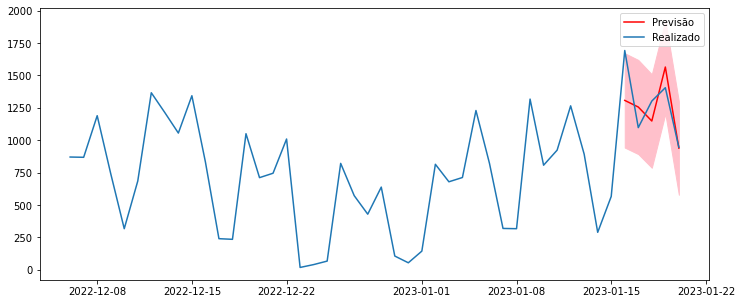

In [19]:
#Gráfico com a previsão vs realizado
plt.figure(figsize=(12,5))
plt.plot(datas_previsao, previsao_media.values, color='red', label='Previsão')
plt.fill_between(datas_previsao, limites_abaixo, limites_acima, color='pink')
plt.plot(datas, vendas['Vendas'].values, label='Realizado')
plt.legend()
plt.show()

In [20]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rmse_sarima = sqrt(mean_squared_error(vendas['Vendas'][-5:].values,previsao_media.values))
print(rmse_sarima)

211.0383220069287


In [21]:
#Previsão para os próximos 5 dias
forecast = resultado_arima.get_forecast(steps=5)
forecast_medio = forecast.predicted_mean

In [24]:
datas_forecast = np.asarray(forecast_medio.index)

In [22]:
#intervalo de confiança
intervalo_confianca_forecast = forecast.conf_int()
intervalo_abaixo_f = intervalo_confianca_forecast.iloc[:,0]
intervalo_acima_f = intervalo_confianca_forecast.iloc[:,1]

intervalo_abaixo_f[4], intervalo_acima_f[4]

(685.9179992010982, 1796.625369186495)

### Resultado

In [29]:
vendas['Vendas'].tail(10)

Data
2023-01-11     923
2023-01-12    1265
2023-01-13     892
2023-01-14     289
2023-01-15     566
2023-01-16    1692
2023-01-17    1097
2023-01-18    1302
2023-01-19    1405
2023-01-20     945
Name: Vendas, dtype: int64

In [ ]:
#valores previstos
forecast_medio

2023-01-21     576.352446
2023-01-22     703.661340
2023-01-23    1554.651721
2023-01-24    1215.196263
2023-01-25    1241.271684
Freq: D, Name: predicted_mean, dtype: float64

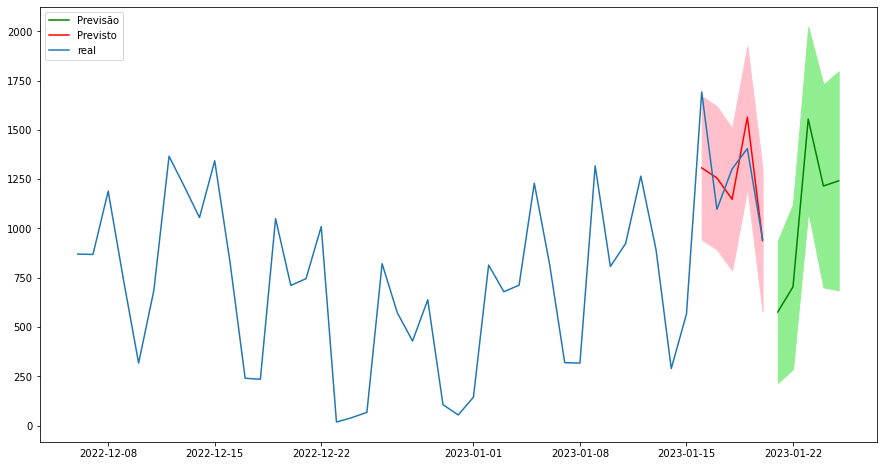

In [26]:
datas=np.asarray(vendas.index)
plt.figure(figsize=(15,8))
plt.plot(datas_forecast,forecast_medio.values,color='green',label='Previsão')
plt.fill_between(datas_forecast, intervalo_abaixo_f, intervalo_acima_f, color='lightgreen')

plt.plot(datas_previsao,previsao_media.values,color='red',label='Previsto')
plt.fill_between(datas_previsao, limites_abaixo, limites_acima, color='pink')

plt.plot(datas,vendas['Vendas'].values, label='real')
plt.legend(loc='upper left')
plt.show()